# Speed comparison for reading between io.ascii, Pandas, and numpy.genfromtxt

This notebook provides speed comparisons for reading ASCII data tables using a few different methods:

* io.ascii.read using the legacy pure-Python reader
* io.ascii.read using the fast C-based reader with the standard string-to-double converter
* io.ascii.read using the fast C-based reader with a faster string-to-double converter
* pandas.read_csv
* numpy.genfromtxt

The data tables themselves are space-delimited tables with variations in length, number of columns, and composition (how many columns of each data type: int, float, str).

#### Summary
[tested under OS X 10.12  for AstroPy 1.3]
* The io.ascii fast-C reader with standard conversion is about 3 to 4 times faster than the pure-Python version for pure floating-point data, and up to 10 times for integer values.
* Using the fast string-to-double converter bumps the `io.ascii` speed gain to 8 - 12 times for reading floats, about 50% faster than Pandas.
* The fast converter carries some overhead for table sizes up to some hundred to a few thousand rows. Enabling automatic format detection / `guess=True` introduces additional performance penalties for tables up to several thousand rows and largely voids the advantage over Pandas.

#### Import modules

In [1]:
import timeit
from astropy.io import ascii
import pandas
import numpy as np
from astropy.table import Table, Column
from tempfile import NamedTemporaryFile
import random
import string
import matplotlib.pyplot as plt
%matplotlib inline

#### Create a table with custom random values

In [53]:
def make_table(table, size, n_floats, n_ints, n_strs, n_exp, float_format, str_val):
    cols = []
    for i in range(n_floats):
        dat = np.random.uniform(low=1, high=10, size=size) # random float values from 1 to 10
        cols.append(Column(dat, name='f{}'.format(i)))
    for i in range(n_ints):
        dat = np.random.randint(low=-9999999, high=9999999, size=size) # random integers
        cols.append(Column(dat, name='i{}'.format(i)))
    for i in range(n_strs):
        if str_val == 'random':
            # use random 10-letter strings
            dat = np.array([''.join([random.choice(string.ascii_letters) for j in range(10)]) for k in range(size)])
        else:
            dat = np.repeat(str_val, size) # repeat str_val
        cols.append(Column(dat, name='s{}'.format(i)))
    for i in range(n_exp):     # random floats in exp notation covering ~ float64 range
        dat = 10.0**np.random.uniform(low=-290, high=280, size=size)*(2*np.random.randint(low=0, high=2, size=size)-1)
        cols.append(Column(dat, name='e{}'.format(i)))
    t = Table(cols)

    if float_format is not None:
        # Set format for float columns
        for col in t.columns.values():
            if col.name.startswith('f'):
                col.format = float_format
            elif col.name.startswith('e'):
                col.format = float_format.replace('f', 'e')

    t.write(table.name, format='ascii', overwrite=True) # output to temporary file

#### Test each reader and plot the results

In [87]:
def plot_case(n_floats=10, n_ints=0, n_strs=0, n_exp=0, float_format=None, str_val="abcde12345", genfromtxt=True, **fast_args):
    global table1
    n_rows = (100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000)  # include 50000 for publish run
    numbers = (10,  10,   5,    2,    1,    1,     1,     1,    1,    1)
    repeats =  (3,   3,   3,    3,    3,    3,     3,     2,    1,    1)
    # store times for each reader in lists
    times_slow = []
    times_fast = []
    times_fast_converter = []
    times_pandas = []
    times_genfromtxt = []
    for n_row, number, repeat in zip(n_rows, numbers, repeats):
        table1 = NamedTemporaryFile() # write to a temporary file
        make_table(table1, n_row, n_floats, n_ints, n_strs, n_exp, float_format, str_val)
        # slow reader
        t = timeit.repeat("ascii.read(table1.name, format='basic', guess=False, fast_reader=False)", 
                   setup='from __main__ import ascii, table1', number=number, repeat=repeat)
        times_slow.append(min(t) / number)
        # fast reader
        t = timeit.repeat("ascii.read(table1.name, format='basic', guess=False)", 
                   setup='from __main__ import ascii, table1', number=number, repeat=repeat)
        times_fast.append(min(t) / number)
        if n_floats > 0 or n_exp > 0:
            # fast reader with fast converter if the table contains floats
            fast_reader = dict(use_fast_converter=True)
            fast_reader.update(fast_args)
            t = timeit.repeat("ascii.read(table1.name, format='basic', guess=False, fast_reader={})".format(fast_reader),
                   setup='from __main__ import ascii, table1', number=number, repeat=repeat)
            times_fast_converter.append(min(t) / number)
        # Pandas
        t = timeit.repeat("pandas.read_csv(table1.name, sep=' ', header=0)", 
                   setup='from __main__ import table1, pandas', number=number, repeat=repeat)
        times_pandas.append(min(t) / number)
        if genfromtxt:
            # numpy's genfromtxt
            t = timeit.repeat("np.genfromtxt(table1.name, names=True)", 
                   setup='from __main__ import table1, np', number=number, repeat=repeat)
            times_genfromtxt.append(min(t) / number)
    # plot points
    plt.loglog(n_rows, times_slow, '-ob', label='io.ascii Python')
    plt.loglog(n_rows, times_fast, '-or', label='io.ascii Fast-c')
    if n_floats > 0 or n_exp > 0:
        plt.loglog(n_rows, times_fast_converter, '-oy', label='Fast converter')
    plt.loglog(n_rows, times_pandas, '-oc', label='Pandas')
    if genfromtxt:
        plt.loglog(n_rows, times_genfromtxt, '-om', label='np.genfromtxt', alpha=0.5)
    plt.grid()
    plt.legend(loc='best')
    plt.xlabel('Number of rows')
    plt.ylabel('Time (sec)')
    print('Fast-C to Python speed ratio: {:.2f} : 1'.format(times_slow[-1] / times_fast[-1]))
    if n_floats > 0 or n_exp > 0:
        print('Fast-C with converter to Fast-C speed ratio: {:.2f} : 1'.format(times_fast[-1] / times_fast_converter[-1]))
        print('Pandas to Fast-C with converter speed ratio: {:.2f} : 1'.format(times_fast_converter[-1] / times_pandas[-1]))
    else:
        print('Pandas to Fast-C speed ratio: {:.2f} : 1'.format(times_fast[-1] / times_pandas[-1]))
    plt.title(r'$n_\mathrm{{exp}}={:d}\,\,n_\mathrm{{floats}}={:d}\,\,n_\mathrm{{ints}}={:d}\,\,n_\mathrm{{strs}}={:d}\,\,\mathrm{{float\_format}}={:s}$'.format(n_exp, n_floats, n_ints, n_strs, float_format or 'default'))

#### Floating-point values

Fast-C to Python speed ratio: 3.44 : 1
Fast-C with converter to Fast-C speed ratio: 2.62 : 1
Pandas to Fast-C with converter speed ratio: 0.66 : 1


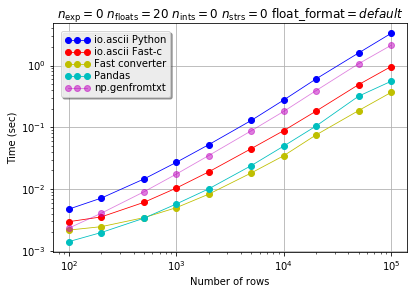

In [92]:
plot_case(n_floats=20, n_ints=0, n_strs=0, float_format=None)

#### Floating-point - exponential notation
You can try different fast_reader options, e.g. `parallel=True` or the various `exponent_style` options in 1.3, but note that the read in values are not checked, so any style other than `E`, `A` or `Fortran` will effectively result in string reading!

Fast-C to Python speed ratio: 2.65 : 1
Fast-C with converter to Fast-C speed ratio: 3.37 : 1
Pandas to Fast-C with converter speed ratio: 0.62 : 1


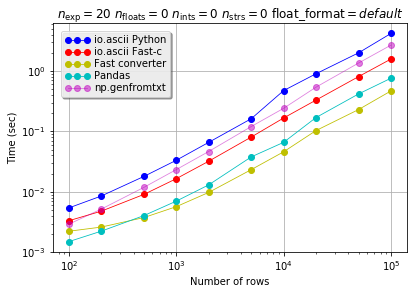

In [96]:
plot_case(n_floats=0, n_ints=0, n_strs=0, n_exp=20, float_format=None, exponent_style='fortran')

#### Mixture of data types

Fast-C to Python speed ratio: 5.26 : 1
Fast-C with converter to Fast-C speed ratio: 1.96 : 1
Pandas to Fast-C with converter speed ratio: 0.61 : 1


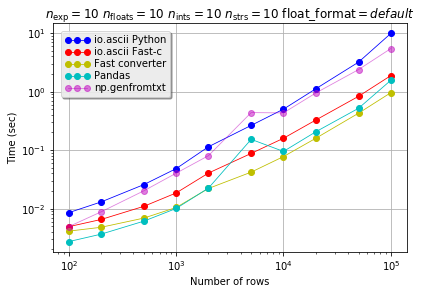

In [93]:
plot_case(n_floats=10, n_ints=10, n_strs=10, n_exp=10, float_format=None)

#### Mixture of data types with low-precision floating-point values

Fast-C to Python speed ratio: 6.31 : 1
Fast-C with converter to Fast-C speed ratio: 1.26 : 1
Pandas to Fast-C with converter speed ratio: 0.82 : 1


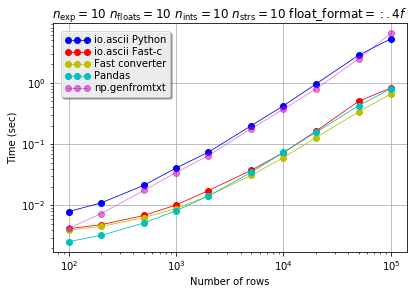

In [33]:
plot_case(n_floats=10, n_ints=10, n_strs=10, n_exp=10, float_format='{:.4f}')

#### Low-precision floating-point values

Fast-C to Python speed ratio: 9.10 : 1
Fast-C with converter to Fast-C speed ratio: 1.28 : 1
Pandas to Fast-C with converter speed ratio: 0.56 : 1


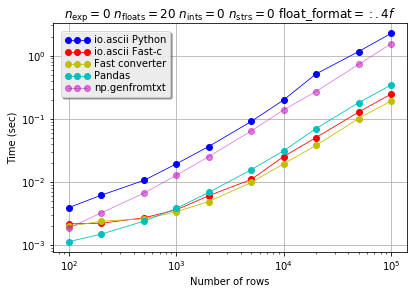

In [94]:
plot_case(n_floats=20, n_ints=0, n_strs=0, float_format='{:.4f}')

#### Low-precision exponential-notation values

Fast-C to Python speed ratio: 2.66 : 1
Fast-C with converter to Fast-C speed ratio: 4.24 : 1
Pandas to Fast-C with converter speed ratio: 0.58 : 1


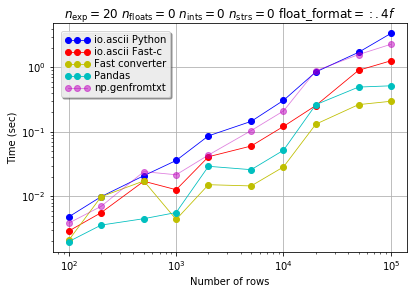

In [95]:
plot_case(n_floats=0, n_ints=0, n_strs=0, n_exp=20, float_format='{:.4f}')

#### String values

Fast-C to Python speed ratio: 3.84 : 1
Pandas to Fast-C speed ratio: 2.22 : 1


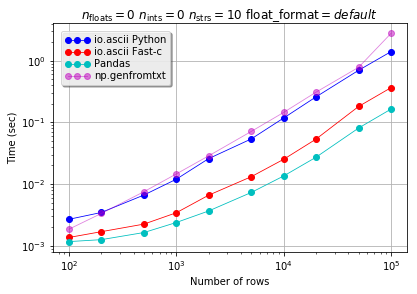

In [11]:
plot_case(n_floats=0, n_ints=0, n_strs=10)

#### Quoted string values

Fast-C to Python speed ratio: 3.48 : 1
Pandas to Fast-C speed ratio: 3.09 : 1


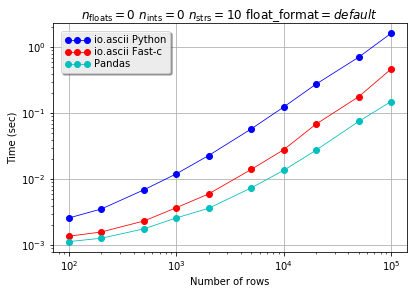

In [12]:
plot_case(n_floats=0, n_ints=0, n_strs=10, str_val="'asdf asdfa'", genfromtxt=False)

#### Randomized string values

Fast-C to Python speed ratio: 4.58 : 1
Pandas to Fast-C speed ratio: 0.54 : 1


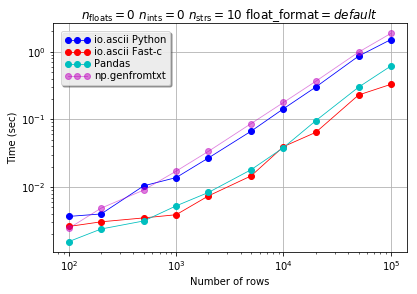

In [15]:
plot_case(n_floats=0, n_ints=0, n_strs=10, str_val="random")

#### Integer values

Fast-C to Python speed ratio: 14.97 : 1
Pandas to Fast-C speed ratio: 0.93 : 1


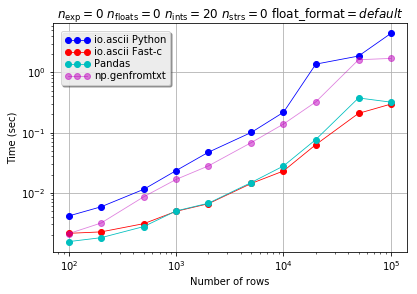

In [89]:
plot_case(n_floats=0, n_ints=20, n_strs=0)